In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Boosting

The concept behind boosting is to train a family of estimators, denoted as $est_1, \dots, est_M$, in a way that during the training of $est_{m+1}$, emphasis is placed on correcting the errors made by $est_m$. The final prediction is achieved through a weighted average of the predictions from each individual estimator. In boosting algorithms, individual estimators typically employ decision trees with limited depth.

# Forward Stagewise Additive Modeling

In forward stagewise additive modeling, the process begins with a problem-specific loss function $L$. Inductively, one selects the optimal pair of estimator and coefficient, denoted as $\alpha_m, est_m$, to minimize the following expression with respect to $\alpha, est$:
$$\sum_{i=1}^N L\left(y_i, \alpha \, est(x_i) + \sum_{j=1}^{m-1} \alpha_j est_j(x_i) \right).$$
The algorithm can be written precisely as follows:

- Let $f_0=0$
- **for** $m=1,\dots,M$:
 - $\alpha_m, est_m= 
 \underset{\alpha, est}{\text{argmin}} \frac{1}{N} \sum_{i=1}^N L\left(y_i, f_{m-1}(x_i)+\alpha \, est(x_i) \right)$
 - $f_m = f_{m-1}+\alpha_m est_m$
 
How we use $(\alpha_m,est_m)_{m=1}^M$ for predictions depends on the interpretation of the minimizer of the loss function.

## Exponential loss for classification

Let $X,Y$ be random variables where $Y$ takes values $1,\dots,K$. Let $\mathcal{Y}$ denote the $\mathbb{R}^K$ valued random variable defined by
$$\mathcal{Y}_k = \begin{cases}
\frac{K-1}{K} & Y=k \\
\frac{-1}{K} & Y \neq k
\end{cases}$$
Let us define exponential loss $L(Y,f(X))$ of $\mathbb{R}^K$ valued random variable $f(X)$ by
$$e^{-\mathcal{Y}\cdot f(X)} $$
Let us see how does the function $f(x)$ minimizing the expected loss express. We have
$$f(x) = \underset{v \in \mathbb{R}^k}{\text{argmin}} \, \mathbb{E}[e^{-\mathcal{Y}\cdot v}|X=x] $$
Note that value of the loss does not change if we add the same constant to all entries of $v$, since the sum of the entries of $\mathcal{Y}$ is $0$. Hence, we can assume that $v_1 + \dots + v_K=0$. With this assumption, we get
$$-\mathcal{Y}\cdot v = \frac{1}{K}\left(\sum_{k=1,\dots,K,\, k \neq Y}v_k \right) - \frac{K-1}{K}v_Y = -v_Y $$
The expectation becomes
$$\begin{equation*}
    \begin{split}
        \mathbb{E}[e^{-v_Y}|X=x] &= 
        &= \sum_{j=1}^K e^{-v_j} \mathbb{P}(Y=j|X=x)
    \end{split}
\end{equation*}$$
which is a convex function of $v$. Applying Lagrange multipliers, we get
$$f(x)_k=\log\left( \mathbb{P}(Y=k|X=x) \right) - \frac{1}{K}\sum_{j=1}^K \mathbb{P}(Y=j|X=x)$$
Therefore, for the exponential loss minimizing $f(X)$, $$\underset{k=1,\dots,K}{\text{argmax}}f(X)_k$$ is a good estimator of $Y$. 

## Forward stagewise additive modeling with exponential loss

To use exponential loss, we are going to think each classifier $est_m$ as $\mathbb{R}^K$ valued by one hot encoding the original classifier. We are also assuming that $y_i$'s are one hot encoded. 

Let $(\alpha_1,est_1),\dots,(\alpha_m,est_m)$ be the outputs of the forward stagewise additive modeling with exponential loss function. To analyze this output, we introduce the following notation.
- $y_{m,i} = est_m(x_i)$ for $i=1,\dots,N$, $m=1,\dots,M$
- $w_{m,i}=C_m\,\prod_{j=1}^{m-1}e^{-\alpha_i \mathcal{Y}_i \cdot y_{j,i}}$ for $i=1,\dots,N$, $m=1,\dots,M$. We are assuming $\alpha_m \geq 0$. Here, $C_m$ is the normalizing constant ensuring $\sum_{i=1}^N w_{m,i}=1$. Note that $w_{1,i}=1/N$ for all $i$.
- $err_m=\sum_{i=1}^N w_{m,i}I(y_i \neq y_{m,i})$, the weighted error rate of the estimator $est_m$.

Under this notation, $(\alpha_m, est_m)$ becomes the minimizer of the following expression
$$\begin{equation*}
    \begin{split}
        \sum_{i=1}^N w_{m,i}e^{-\alpha_m \mathcal{Y}_i \cdot y_{m,i}} &= \sum_{i=1}^N w_{m,i}e^{\alpha_m/K} I(y_i \neq y_{m,i}) + \sum_{i=1}^N w_{m,i}e^{-(K-1)\alpha_m/K} I(y_i = y_{m,i}) \\
                                                                      &= \left(e^{\alpha_m/K}-e^{-(K-1)\alpha_m/K}\right) \left(\sum_{i=1}^N w_{m,i} I(y_i \neq y_{m,i}) \right) + e^{-(K-1)\alpha_m/K}\sum_{i=1}^N w_{m,i}\\
                                                                      &= \left(e^{\alpha_m/K}-e^{-(K-1)\alpha_m/K}\right)err_m + e^{-(K-1)\alpha_m/K}
    \end{split}
\end{equation*}$$

In the final expression, only $err_m$ depends on $est_m$, hence $est_m$ is the estimator miniminizing the weighted error rate with weights $(w_{m,i})_{i=1}^n$. Differentiating the expression with respect to setting it to zero, we get
$$\alpha_m =\log \beta_m, \quad\text{where}\, \beta_m= \max\left(1, (K-1)\frac{1-err_m}{err_m} \right) $$

Now, let see how to obtain $w_{m+1,i}$ from $w_{m,i}$. We have
$$w_{m+1}=\begin{cases}
C e^{-(K-1)\alpha_m/K} w_{m,i} & y_i = y_{m,i} \\
C e^{\alpha_m/K} w_{m,i} & y_i \neq y_{m,i}
\end{cases}$$
for some normalizing constant. If we let $\bar{C}=C e^{-(K-1)\alpha_m/K}$, then we get
$$w_{m+1}=\begin{cases}
\bar{C} w_{m,i} & y_i = y_{m,i} \\
\bar{C} e^{\alpha_m} w_{m,i} & y_i \neq y_{m,i}
\end{cases}$$
Hence, we can obtain $w_{m+1,i}$'s from $w_{m,i}$'s, by multiplying the weights of points misclassified by $est_m$ by $\beta_m=e^{\alpha_m}$, and then normalizing.

Using the analysis above, we end up with the following algorithm for classification with $K$ classes:

- Initialize $w_1=[1/N,\dots,1/N]$
- **for** $m=1,\dots,M$:
 - Fit $est_m$ on $(X,y)$ with weights $w_m$
 - Calculate the weighted error rate $err_m = \sum_{i=1}^N w_{m,i}I(y_i \neq est_m(x_i))$
 - $\beta_m = \max(1, (K-1)(1-err_m)/err_m )$
 - $\alpha_m = \log \beta_m$
 - **for** $i=1,\dots,N$, **if** $y_i \neq est_m{y_i}$:
   - $w_{m+1,i}=\beta_m w_{m,i}$
 - Normalize $(w_{m+1,i})_{i=1}^N$ to ensure that the sum is $1$.
- The prediction for input $x$ is given by
$$\underset{k=1,\dots,K}{\text{argmax}} \sum_{m=1}^M \alpha_m I(est_m(x)=k)  $$

This algorithm for binary classification was called AdaBoost. This multiclass version is called SAMME — Stagewise Additive Modeling using a Multi-class Exponential loss function.

# SAMME Implementation

In [2]:
class SAMME:
    def __init__(self,num_estimators=20, max_depth=2,random_state=13):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
        self.estimators = [None]*num_estimators
        self.random_state=random_state
    def fit(self,X,y):
        N=X.shape[0]
        K = len(set(y))
        weights=np.ones(N)/N
        for m in range(self.num_estimators):
            T = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            T.fit(X,y, sample_weight=weights)
            y_pred = T.predict(X)
            err = (y_pred!=y)@weights
            beta = max(1,(1-err)/(err+0.00001) )
            alpha = np.log(beta)
            self.estimators[m]=(alpha,T)
            weights[y!=y_pred] *= beta
            weights /= weights.sum()
    def predict(self,X):
        result = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            weights = {}
            for alpha, est in self.estimators:
                c = est.predict([x])[0]
                weights[c]=weights.get(c,0)+alpha
            result[i] = max(weights.keys(), key = lambda c: weights[c])
        return result

## Example

In [3]:
#create a dataset
np.random.seed(13)
N=1250
X = np.random.uniform(-1,1,(N,9))
y = 1*(X.sum(axis=1)>=0) + 1*(X.sum(axis=1)>=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#train a decision tree classifier
dt = DecisionTreeClassifier(max_depth=20,random_state=13)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
acc_dt = (y_test == y_pred).mean()

#train an SAMME classifier
est = SAMME(max_depth=4,num_estimators=100)
est.fit(X_train,y_train)
y_pred=est.predict(X_test)
acc_boost = (y_test==y_pred).mean()

print(f'Decision tree with max_depth=20, test accuracy:{acc_dt:.2f}')
print(f'SAMME classifier with 100 decision tree estimators of max_depth=4, test accuracy:{acc_boost:.2f}')

Decision tree with max_depth=20, test accuracy:0.63
SAMME classifier with 100 decision tree estimators of max_depth=4, test accuracy:0.84


# Gradient Boosting for Regression

In gradient boosting for regression with a loss function  $L(y,f(x))$, the process begins with the constant function  $f_0 = C$ that minimizes the total loss. Then, iteratively for  $m = 1 , \dots , M$, an estimator  $est_m$   is fitted to the negative gradient  $\partial L(x,z)/ \partial z$ at  $z=f_{m−1}(x)$ to determine a direction of decrease for the loss. Subsequently, the best scalar $\alpha_m$ is found to minimize the expression:
$$\sum_{i=1}^N L(y_i, f_{m-1}(x_i)+\alpha_m est_m(x_i))$$
and $f_m$ is updated as $f_m = f_{m-1}+\alpha_m est_m$. The final estimator $f_M$ is then utilized for predictions. 

The algorithm can be written as follows:

- $f_0 = \underset{C}{\text{argmin}} \sum_{i=1}^N L(y_i,C)$
- **for** $m=1,\dots,M$:
 - Fit an estimator $est_m$ to the training data $$\left(x_i, \frac{\partial L(y_i,z)}{\partial z} \bigg|_{z=f_{m-1}(x_i)} \right)$$
 - $\alpha_m = \underset{\alpha}{\text{argmin}} \sum_{i=1}^N L \big(y_i,f_{m-1}(x_i) + \alpha \,est_m(x_i) \big)$
- The prediction for an input $x$ is $f_M(x)$.

This algorithm can be adapted for classification. If one uses multinomial cross entropy for loss, then at each $m$, one needs the train an estimator for each class for the corresponding partial derivative of the loss.

Let us see how this regression algorithm can be implemented for the squared error function $L(y,z)=(y-z)^2$, where the estimators are decision tree regressors. First of all, we have $f_0 = C$, where $C$ is the mean of $(y_i)_{i=1}^N$. Let $r_{m,i}=y_i - f_{m-1,i}$ for $i=1,\dots,N$. Since $-\partial L(x,z)/\partial z=2(y-z)$,  $est_m$ can be fitted to the data $(x_i, r_{m,i}) $. Let $R_1,\dots,R_n$ be the regions in $\mathbb{R}^p$ corresponding to the leaves of $est_m$. For $j=1,\dots,n$, let $\mu_j$ denote the constant value that $est_m$ takes over $R_j$. We have, 
$$\mu_j= \text{mean}[r_{m,i}: \text{ for } i \text{ such that } x_i \in R_j]$$ With this notation, $\alpha_m$ becomes the minimizer of the expression:
$$\sum_{j=1}^n\sum_{i:\, x_i \in R_j}(r_{m,i}-\alpha\,\mu_j)^2$$
For each $j$, $\alpha=1$ is the minimizer of $\sum_{i:\, x_i \in R_j}(r_{m,i}-\alpha\,\mu_j)^2$. Hence, $\alpha_m=1$. Now, the algorithm becomes

- $f = \text{mean}([y_i \text{ for } i=1,\dots,N])$ 
- $r=y-mean$
- **for** $m=1,\dots,M$:
 - fit a decision tree regressor $est$ to $(X,r)$
 - $\hat{r}=est.predict(X)$
 - $r = r -  \hat{r}$
 - $f = f +  est$

## Gradient boosting regressor implementation

In [4]:
class GradientBoostingRegressor:
    def __init__(self,num_estimators=100,max_depth=4):
        self.num_estimators=num_estimators
        self.max_depth=max_depth
        self.estimators=[None]*num_estimators
        self.mean=None
    def fit(self,X,y):
        self.mean = y.mean()
        r = y - self.mean
        for m in range(self.num_estimators):
            est = DecisionTreeRegressor(max_depth=self.max_depth)
            est.fit(X,r)
            r_hat=est.predict(X)
            self.estimators[m]=est
            r = r - r_hat
            
    def predict(self,X,history=False):
        preds = np.append(
            self.mean*np.ones((1,X.shape[0])),
            np.array([est.predict(X) for est in self.estimators]),axis=0
        ).T
        if history:
            return preds.cumsum(axis=1)
        return preds.sum(axis=1)

## Example

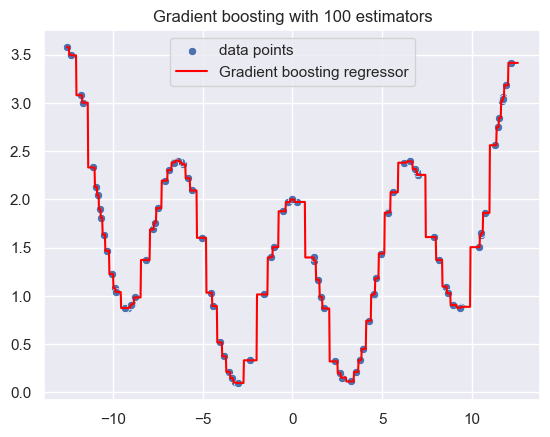

In [5]:
N = 100
np.random.seed(13)
X = np.random.uniform(-4*np.pi,4*np.pi,(N,1))
y = (np.cos(X)+X**2/100+1).reshape(N)
sns.scatterplot(x=X[:,0],y=y,label='data points')

est = GradientBoostingRegressor(num_estimators=100)
est.fit(X,y)

xs=np.linspace(-4*np.pi,4*np.pi, 1000)
results=est.predict(xs.reshape(1000,1),history=True)
ys=results[:,-1]
sns.lineplot(x=xs,y=ys,color='red',label='Gradient boosting regressor')

plt.title(f'Gradient boosting with {est.num_estimators} estimators')
plt.legend();

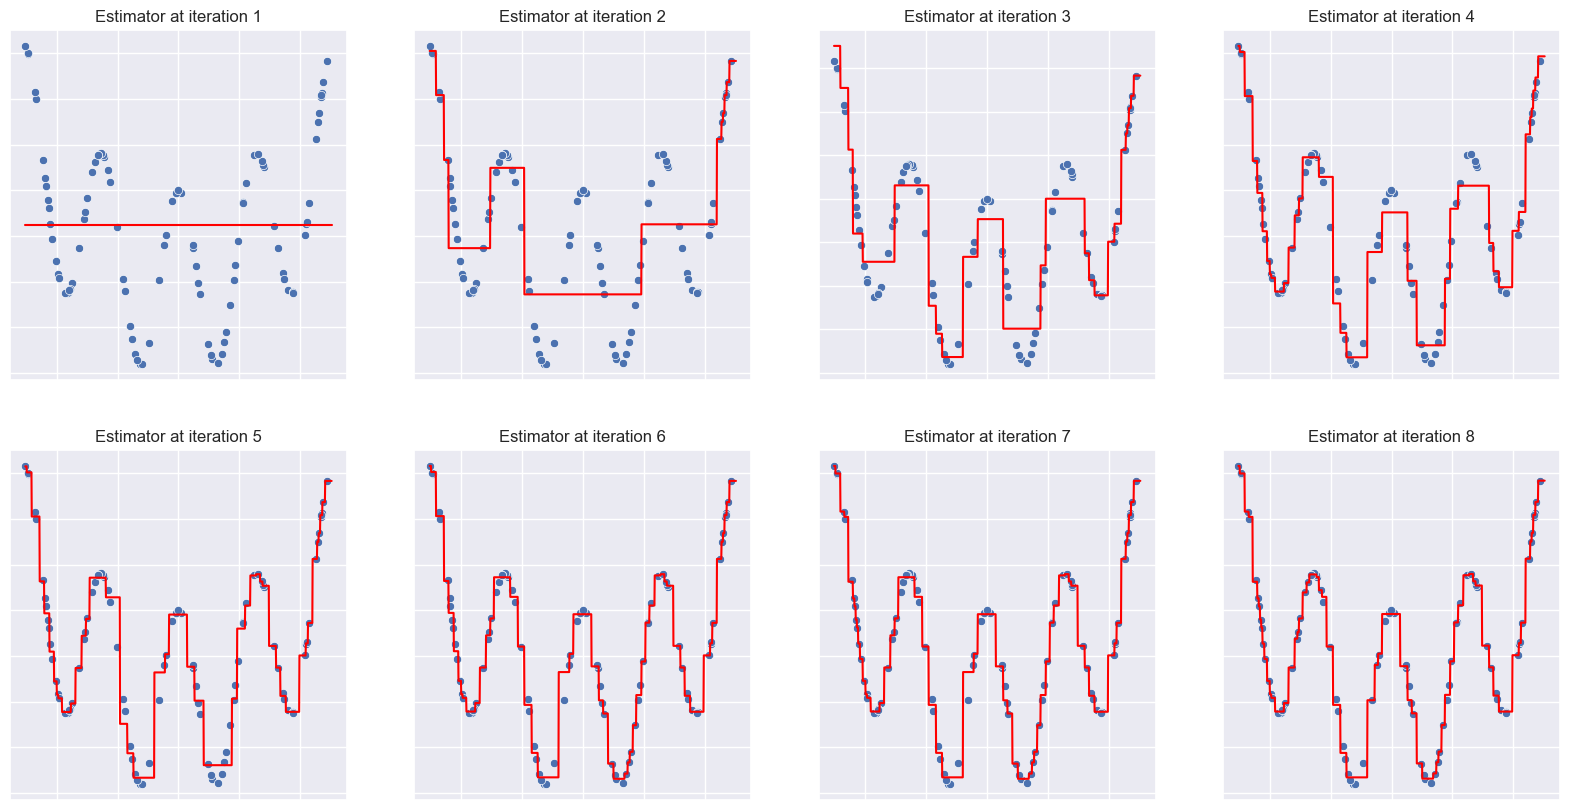

In [6]:
M=8
fig = plt.figure(figsize=(20,10))
for i in range(M):
    ax = fig.add_subplot(2,M//2,i+1)
    sns.scatterplot(x=X[:,0],y=y,ax=ax)
    ys = results[:,i]
    sns.lineplot(x=xs,y=ys,ax=ax,color='red')
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    ax.set_title(f'Estimator at iteration {i+1}')